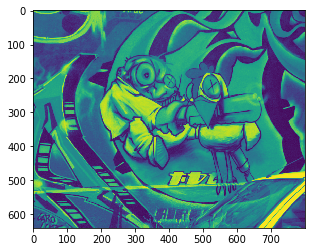

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import numpy as np
import kornia
from kornia.feature import *
from time import time

img1 = Image.open('img/test-graf/img1.png').convert('L')
img2 = Image.open('img/test-graf/img3.png').convert('L')
H = np.loadtxt('img/test-graf/H1to3p')
timg = kornia.utils.image_to_tensor(np.array(img1)).float() / 255.
timg2 = kornia.utils.image_to_tensor(np.array(img2)).float() / 255.

timg = timg.view(1, 1, *timg.shape)  # 1xCxHxW
timg2 = timg2.view(1, 1, *timg2.shape)  # 1xCxHxW
timg = torch.cat([timg,timg2],dim=0)
plt.imshow(kornia.utils.tensor_to_image(timg[0,0]))


In [9]:
device = torch.device('cuda:0')

sift = kornia.feature.SIFTDescriptor(41).to(device)
detector = ScaleSpaceDetector(3000, resp=HessianResp(False,False,False)).to(device)
timg = timg.to(device)
t=time()
lafs, resps = detector(timg)
descs = sift.describe_lafs(timg, normalize_LAF(lafs,timg))
print (time() - t, ' s for detection & description')

0.05355191230773926  s for detection & description


In [10]:
def distance_matrix(anchor, positive):
    """Given batch of descriptors calculate distance matrix"""
    #https://github.com/DagnyT/hardnet/blob/master/code/Losses.py#L5
    d1_sq = torch.sum(anchor * anchor, dim=1).unsqueeze(-1)
    d2_sq = torch.sum(positive * positive, dim=1).unsqueeze(-1)

    eps = 1e-6
    return torch.sqrt((d1_sq.repeat(1, positive.size(0)) + torch.t(d2_sq.repeat(1, anchor.size(0)))
                      - 2.0 * torch.bmm(anchor.unsqueeze(0), torch.t(positive).unsqueeze(0)).squeeze(0))+eps)

def match_snn(desc1, desc2):
    dm = distance_matrix(desc1,
                         desc2)
    vals, idxs_in_2 = torch.topk(dm, 2 ,dim=1, largest=False)
    snn_ratio = vals[:,0] / vals[:,1]
    mask = snn_ratio <= 0.8
    idxs_in1 = torch.arange(0, idxs_in_2.size(0))[mask]
    idxs_in_2 = idxs_in_2[:,0][mask]
    matches_idxs = torch.cat([idxs_in1.view(-1,1), idxs_in_2.cpu().view(-1,1)],dim=1)
    return matches_idxs

matches = match_snn(descs[0], descs[1])


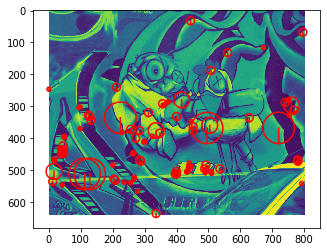

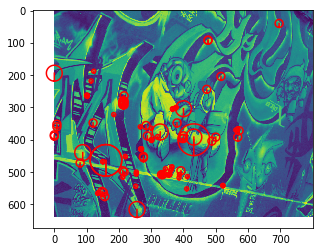

In [11]:
#Lets draw matches
for idx in range(2):
    kornia.feature.laf.visualize_LAF(timg,
                                     lafs[:,matches[:,idx]],
                                     idx,
                                    color = 'r')